In [45]:
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt


In [46]:
basepath = "/mnt/fast/ads/data/"

In [47]:
clicks = pd.read_csv(basepath + "clicks.csv", sep=";")
platforms = pd.read_csv(basepath + "platforms.csv", sep=";")
shows = pd.read_csv(basepath + "shows.csv", sep=";", encoding="cp1251")

In [48]:
clicks.head(2)

,id,at,ip,platform_id,campaign_id,teaser_id,city_id,country_code,uid,headers,Unnamed: 10
0,4622019,2017-08-30 13:16:58,83.220.239.97,267,491,25412,9,RU,19a627b51405b6c32294310526d32612,"{""accept-language"":""ru-RU,ru;q=0.8,en-US;q=0.6...",NaN
1,4698697,2017-09-06 10:45:51,83.220.236.148,267,491,25412,9,RU,19a627b51405b6c32294310526d32612,"{""accept-language"":""ru-RU,ru;q=0.8,en-US;q=0.6...",NaN


In [49]:
platforms.head(2)

,platform_id,server,tag_name
0,1004,justlady.ru,Общая
1,1004,justlady.ru,"Медицина, здоровье"


In [50]:
shows.head(2)

,id,at,ip,platform_id,teaser_id,city_id,country_code,uid,referer,campaign_id
0,166018810,2017-08-23 05:02:28,109.238.80.40,267,25412,31,RU,lHr29eJ1178jc7wEqdAR1,http://xn----ctbheahl3bddk6as1a9fb.xn--p1ai/%D...,491
1,166025934,2017-08-23 05:27:03,62.249.150.138,267,25412,33,RU,71122276b8582ef27b0b548fb51ca1c2,http://xn----ctbheahl3bddk6as1a9fb.xn--p1ai/%D...,491


Ищем подозрительных пользователей по числу показов на uid

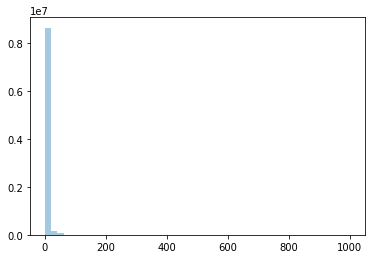

In [51]:
sns.distplot(shows["uid"].value_counts().values, kde=False)
plt.show()

Скорее всего, пользователи с более чем 200 показов - боты, надо их отфильтровать

In [52]:
suspicious_uids = shows["uid"].value_counts()
suspicious_uids = suspicious_uids[suspicious_uids > 200]
suspicious_uids = set(suspicious_uids.index)

In [53]:
shows = shows[~shows["uid"].isin(suspicious_uids)]
clicks = clicks[~clicks["uid"].isin(suspicious_uids)]

In [54]:
shows.head()

,id,at,ip,platform_id,teaser_id,city_id,country_code,uid,referer,campaign_id
0,166018810,2017-08-23 05:02:28,109.238.80.40,267,25412,31,RU,lHr29eJ1178jc7wEqdAR1,http://xn----ctbheahl3bddk6as1a9fb.xn--p1ai/%D...,491
1,166025934,2017-08-23 05:27:03,62.249.150.138,267,25412,33,RU,71122276b8582ef27b0b548fb51ca1c2,http://xn----ctbheahl3bddk6as1a9fb.xn--p1ai/%D...,491
2,166035103,2017-08-23 05:57:38,213.87.249.1,267,25412,9,RU,lUd1ubPcLSZH87haig2,http://xn----ctbheahl3bddk6as1a9fb.xn--p1ai/%D...,491
3,166036146,2017-08-23 06:00:20,178.161.234.0,267,25412,23,RU,lUd21aQ1GcjYQ7Rhiba2,http://xn----ctbheahl3bddk6as1a9fb.xn--p1ai/%D...,491
4,166039286,2017-08-23 06:08:41,176.100.157.115,267,25412,25,RU,lRZ7S8p6217jlC1SiP,http://xn----ctbheahl3bddk6as1a9fb.xn--p1ai/me...,491


**Дескриптивные статистики**

Наивно считаем ctr по парам платформа-тизер как число кликов по этой паре деленное на число показов

In [55]:
grouped_shows = shows.groupby(["platform_id", "teaser_id"])

In [56]:
len(grouped_shows)

36818

In [57]:
clicks = clicks.set_index(["platform_id", "teaser_id"]).sort_index()

In [58]:
platform_teaser_ctr = []

i = 0 #tqdm doesnt work for some reason
for pl_t, group in grouped_shows:
    row = {"platform_id": pl_t[0], "teaser_id": pl_t[1]}
    try:
        click_count = len(clicks.loc[pl_t])
    except:
        click_count = 0
    row["clicks"] =  click_count
    row["shows"] = len(group)
    row["ctr"] = row["clicks"] / row["shows"]
    platform_teaser_ctr.append(row)
    
    i += 1
    if i % 1000 == 0:
        print(i)
        
platform_teaser_ctr = pd.DataFrame(platform_teaser_ctr)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000


Удаляем пары с малым числом показов

In [64]:
platform_teaser_ctr = platform_teaser_ctr[platform_teaser_ctr["shows"] > 100]

Распределение показов:

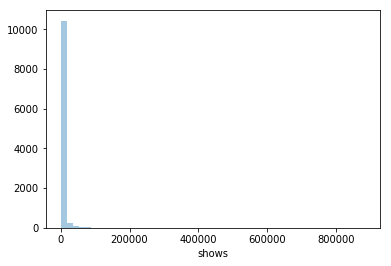

In [65]:
sns.distplot(platform_teaser_ctr["shows"], kde=False)
plt.show()

Удалим пары с малым числом просмотров 

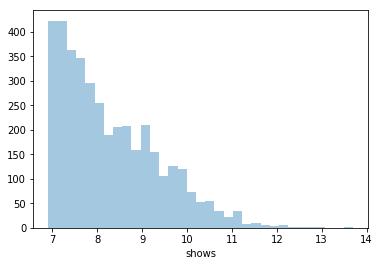

In [66]:
sns.distplot(np.log(platform_teaser_ctr[platform_teaser_ctr["shows"] > 1000]["shows"]), kde=False)
plt.show()

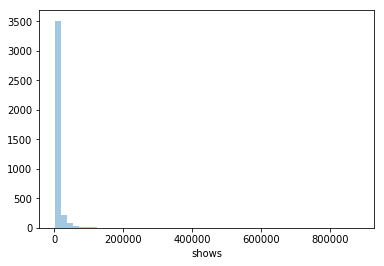

In [67]:
sns.distplot(platform_teaser_ctr[platform_teaser_ctr["shows"] > 1000]["shows"], kde=False)
plt.show()

Распределение ctr

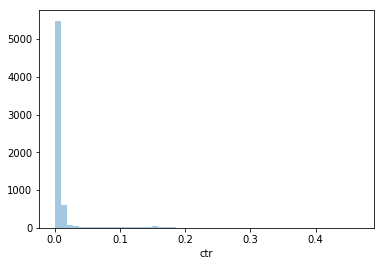

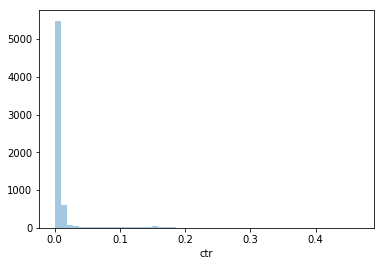

In [78]:
import matplotlib.pyplot as plt
sns.distplot(platform_teaser_ctr[platform_teaser_ctr["ctr"] != 0]["ctr"], kde=False)
plt.show()

sns.distplot(platform_teaser_ctr[platform_teaser_ctr["ctr"] != 0]["ctr"], kde=False)
plt.show()

Собираем "чистый" датасет  

In [79]:
teasers = pd.read_csv(basepath + "teasers.csv", sep=";")

In [80]:
teasers.head()

,campaign_id,teaser_id,url,title,description,image,is_native,is_video,video,creative,button_text,keywords
0,491,25412,http://enterosgel.info/enterosgel-pri-poxudenii/,Энтеросгель – единственный в мире гель от отра...,Узнай подробнее на официальном сайте!,//tt.ttarget.ru/i/t/t_58b56815802bc2.34001936.jpg,0,1,//tt.ttarget.ru/i/t/t_58b5681daec4c4.35091208.mp4,//tt.ttarget.ru/i/t/t_58ec95bf7daf11.29860103.jpg,NaN,NaN
1,491,25495,http://www.6-sotok.ru/,6 Соток - Вам понравится!,"Свежие огурчики, приготовленные по рецептуре ...",//tt.ttarget.ru/i/t/t_58e7417ed16f01.11935925.jpg,0,1,//tt.ttarget.ru/i/t/t_58e740e909fb14.40809357.mp4,//tt.ttarget.ru/i/t/t_58ec93f4151e96.13738439.jpg,NaN,NaN
2,491,25496,http://www.derinat.ru/usefull/sovety-spetsiali...,Деринат - против вирусов!,NaN,//tt.ttarget.ru/i/t/t_58eb42747a0b68.97336120.png,0,1,//tt.ttarget.ru/i/t/t_58eb423b5c1d24.55446644.mp4,//tt.ttarget.ru/i/t/t_58eb4832f264c7.96568569.jpg,NaN,NaN
3,491,25550,https://mense.ru/#kak_prinimat_mense,МЕНСЕ - негормональная поддержка в период мено...,NaN,//tt.ttarget.ru/i/t/t_58f86fdcc3f440.28198879.jpg,0,1,//tt.ttarget.ru/i/t/t_58f86fe429c6e4.13945075.mp4,//tt.ttarget.ru/i/t/t_58f86ff2e773c2.36797722.jpg,NaN,NaN
4,491,25611,http://www.grammidin.ru,Граммидин Нео - лечит больное горло,NaN,//tt.ttarget.ru/i/t/t_58fda64f4a1516.17412691.jpg,0,1,//tt.ttarget.ru/i/t/t_58fda6756a1f05.58910851.mp4,//tt.ttarget.ru/i/t/t_58fda669017ec3.75151782.jpg,NaN,NaN


In [88]:
platforms_merged_tags = []
for pl, group in platforms.groupby("platform_id"):
    platforms_merged_tags.append({"tags": "@".join(group["tag_name"]),\
                                  "platform_id": pl,\
                                  "server": group["server"].iloc[0]})
platforms_merged_tags = pd.DataFrame(platforms_merged_tags)

In [89]:
ctr = pd.merge(platform_teaser_ctr, teasers, left_on="teaser_id", right_on="teaser_id")
ctr = pd.merge(ctr, platforms_merged_tags, left_on="platform_id", right_on="platform_id")

In [90]:
ctr.head()

,clicks,ctr,platform_id,shows,teaser_id,campaign_id,url,title,description,image,is_native,is_video,video,creative,button_text,keywords,server,tags
0,0,0.0,53,1200,25640,516,http://www.heart-sos.ru/articles/56/,Почему болезни сердца «помолодели»?,Неутешительные новости здравоохранения...,//tt.ttarget.ru/i/t/t_58ff57359323b0.49043764.jpg,0,0,\N,\N,NaN,NaN,griboknogtey.ru,"Общая@Новости@Медицина, здоровье@Только наши р..."
1,0,0.0,53,644,25641,516,http://www.heart-sos.ru/articles/56/,Как снизить риск возникновения заболеваний сер...,Новости медицины...,//tt.ttarget.ru/i/t/t_58ff57b583c235.74650094.jpg,0,0,\N,\N,NaN,NaN,griboknogtey.ru,"Общая@Новости@Медицина, здоровье@Только наши р..."
2,0,0.0,53,670,25642,516,http://www.heart-sos.ru/articles/56/,Как сохранить здоровье сердца?,Основные факторы риска!,//tt.ttarget.ru/i/t/t_58ff57ff7649f5.47414731.jpg,0,0,\N,\N,NaN,NaN,griboknogtey.ru,"Общая@Новости@Медицина, здоровье@Только наши р..."
3,0,0.0,53,582,25643,516,http://www.heart-sos.ru/articles/56/,В чем причина возникновения риска сердечных за...,NaN,//tt.ttarget.ru/i/t/t_58ff5c28439fe3.04566075.jpg,0,0,\N,\N,NaN,NaN,griboknogtey.ru,"Общая@Новости@Медицина, здоровье@Только наши р..."
4,0,0.0,53,536,25644,516,http://www.heart-sos.ru/articles/56/,Как нерациональное питание влияет на риск возн...,NaN,//tt.ttarget.ru/i/t/t_58ff5d00d4b9b4.97723055.jpg,0,0,\N,\N,NaN,NaN,griboknogtey.ru,"Общая@Новости@Медицина, здоровье@Только наши р..."


In [92]:
ctr.to_json("ctr_preclean.json")

Сохраним подозрительных юзеров для дальнейшей обработки 

In [95]:
import json

with open("suspicious_uids.json", "w") as outfile:
    outfile.write(json.dumps(list(suspicious_uids)))

Разнятся ли распределения ctr в пределах одной кампании?

516 teaser-host pairs 383


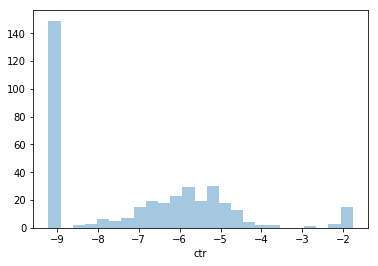

518 teaser-host pairs 442


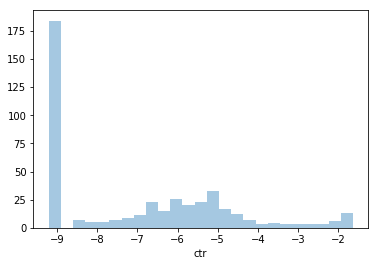

519 teaser-host pairs 98


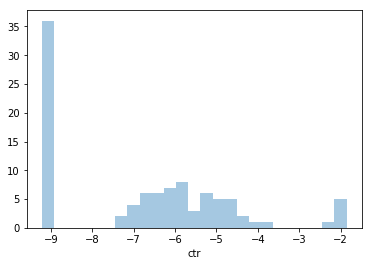

520 teaser-host pairs 158


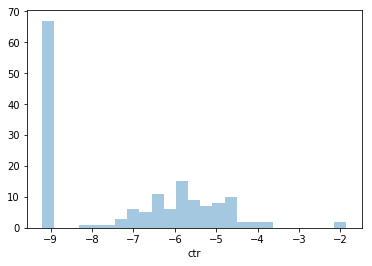

521 teaser-host pairs 262


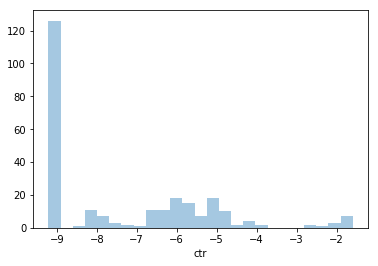

526 teaser-host pairs 407


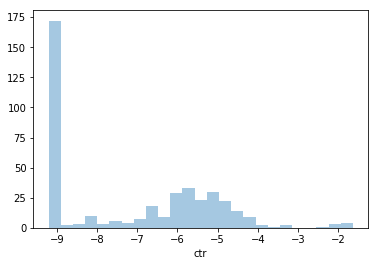

541 teaser-host pairs 742


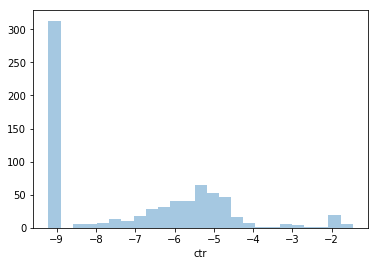

542 teaser-host pairs 768


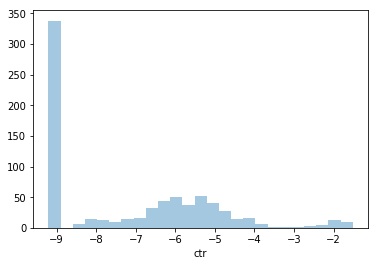

552 teaser-host pairs 971


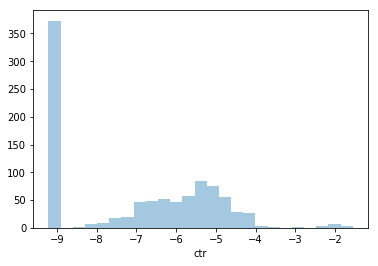

553 teaser-host pairs 200


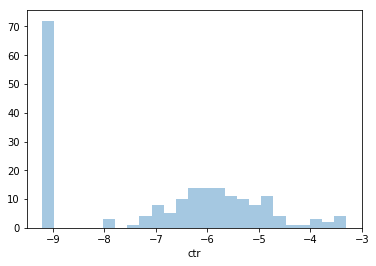

554 teaser-host pairs 717


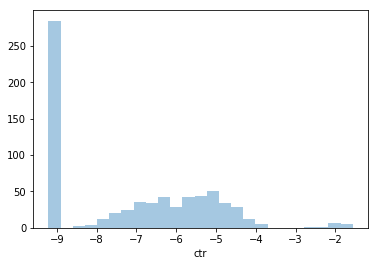

558 teaser-host pairs 598


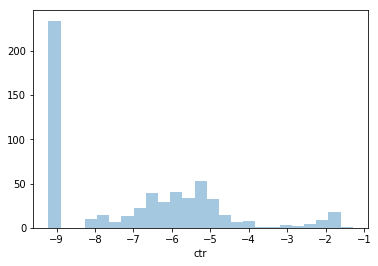

560 teaser-host pairs 218


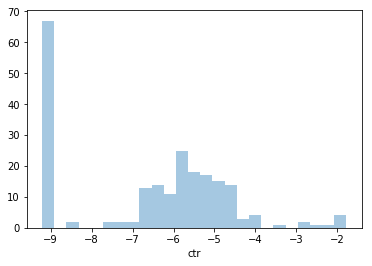

561 teaser-host pairs 227


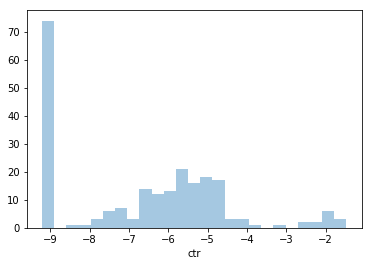

562 teaser-host pairs 213


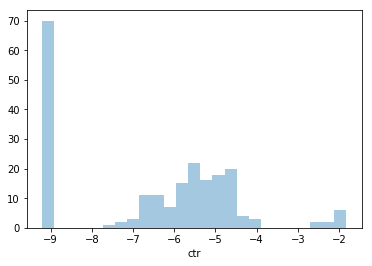

564 teaser-host pairs 935


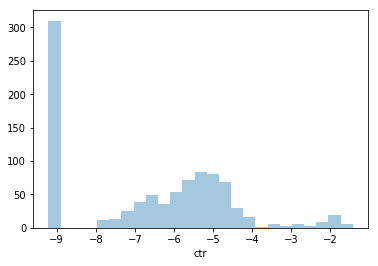

565 teaser-host pairs 1611


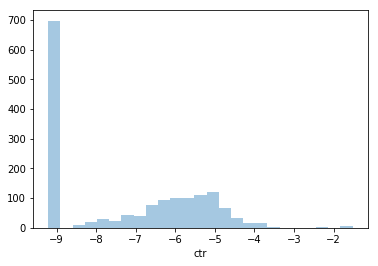

567 teaser-host pairs 432


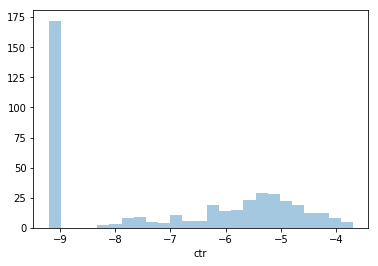

568 teaser-host pairs 343


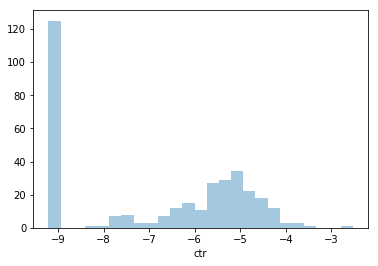

569 teaser-host pairs 561


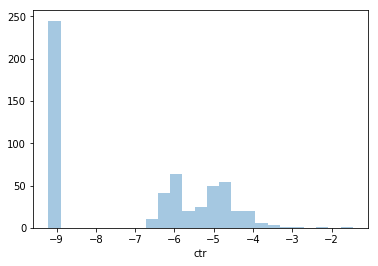

570 teaser-host pairs 567


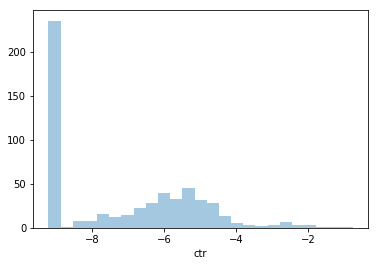

In [105]:
for c_id, group in ctr.groupby("campaign_id"):
    if len(group) > 10:
        print(c_id, "teaser-host pairs", len(group))
        sns.distplot(np.log(group["ctr"] + 0.0001), kde=False, bins=25)
        plt.show()

Да, зачастую распределения ощутимо различаются, значит, имеет смысл пробовать что-то предсказывать.